In [7]:
import sys
import sktime
import tqdm as tq
import xgboost as xgb
import matplotlib
import seaborn as sns
import sklearn as skl
import pandas as pd
import numpy as np
print("-------------------------- Python & library version --------------------------")
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("tqdm version: {}".format(tq.__version__))
print("sktime version: {}".format(sktime.__version__))
print("xgboost version: {}".format(xgb.__version__))
print("seaborn version: {}".format(sns.__version__))
print("scikit-learn version: {}".format(skl.__version__))
print("------------------------------------------------------------------------------")

-------------------------- Python & library version --------------------------
Python version: 3.13.0 (main, Oct  7 2024, 05:02:14) [Clang 16.0.0 (clang-1600.0.26.4)]
pandas version: 2.2.3
numpy version: 2.2.3
matplotlib version: 3.10.0
tqdm version: 4.67.1
sktime version: 0.36.0
xgboost version: 2.1.4
seaborn version: 0.13.2
scikit-learn version: 1.6.1
------------------------------------------------------------------------------


In [8]:
# 0.라이브러리 로드
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 30)

In [10]:
# 데이터 전처리

train = pd.read_csv('./energy/train.csv', encoding = 'cp949')

## 변수들을 영문명으로 변경
cols = ['num', 'date_time', 'power', 'temp', 'wind','hum' ,'prec', 'sun', 'non_elec', 'solar']
train.columns = cols

# 시간 관련 변수들 생성
date = pd.to_datetime(train.date_time)
train['hour'] = date.dt.hour
train['day'] = date.dt.weekday
train['month'] = date.dt.month
train['week'] = date.dt.isocalendar().week

#######################################
## 건물별, 요일별, 시간별 발전량 평균 넣어주기
#######################################
power_mean = pd.pivot_table(train, values = 'power', index = ['num', 'hour', 'day'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['day_hour_mean'] = train.progress_apply(lambda x : power_mean.loc[(power_mean.num == x['num']) & (power_mean.hour == x['hour']) & (power_mean.day == x['day']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 시간별 발전량 평균 넣어주기
#######################################
power_hour_mean = pd.pivot_table(train, values = 'power', index = ['num', 'hour'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train['hour_mean'] = train.progress_apply(lambda x : power_hour_mean.loc[(power_hour_mean.num == x['num']) & (power_hour_mean.hour == x['hour']) ,'power'].values[0], axis = 1)

#######################################
## 건물별 시간별 발전량 표준편차 넣어주기
#######################################
power_hour_std = pd.pivot_table(train, values = 'power', index = ['num', 'hour'], aggfunc = np.std).reset_index()
tqdm.pandas()
train['hour_std'] = train.progress_apply(lambda x : power_hour_std.loc[(power_hour_std.num == x['num']) & (power_hour_std.hour == x['hour']) ,'power'].values[0], axis = 1)

### 공휴일 변수 추가
train['holiday'] = train.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
train.loc[('2020-08-17'<=train.date_time)&(train.date_time<'2020-08-18'), 'holiday'] = 1

# 시간(hour)은 cyclical encoding 하여 변수 추가(sin time & cos time) 후 삭제
# 0시 - 23시는 비슷한 시간임에도 숫자상으론 가장 먼 시간으로 받아들일 수 있기에 시간의 순환적 성격 (cyclical property) 반영
train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)

# THI(불쾌지수) 추가 -> 기온과 습도 고려
train['THI'] = 9/5*train['temp'] - 0.55*(1-train['hum']/100)*(9/5*train['hum']-26)+32

## Cooling Degree Hour 추가 -> 기온이 실제 냉방 가동 시간에 이르기 까지의 시간적 오차 고려
def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,61,1):
    temp = train[train['num'] == num]
    cdh = CDH(temp['temp'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

train.drop(['non_elec','solar','hour'], axis = 1, inplace = True)
train.head()

/var/folders/89/s3dvx5n14_335n4x0tt5mbvw0000gn/T/ipykernel_10722/2776089244.py:19: FutureWarning: The provided callable <function mean at 0x11096a5c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  power_mean = pd.pivot_table(train, values = 'power', index = ['num', 'hour', 'day'], aggfunc = np.mean).reset_index()
100%|██████████| 122400/122400 [00:18<00:00, 6585.33it/s]
/var/folders/89/s3dvx5n14_335n4x0tt5mbvw0000gn/T/ipykernel_10722/2776089244.py:26: FutureWarning: The provided callable <function mean at 0x11096a5c0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  power_hour_mean = pd.pivot_table(train, values = 'power', index = ['num', 'hour'], aggfunc = np.mean).reset_index()
100%|██████████| 122400/122400 [00:13<00:00, 9018.30

,num,date_time,power,temp,wind,hum,prec,sun,day,month,week,day_hour_mean,hour_mean,hour_std,holiday,sin_time,cos_time,THI,CDH
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0,6,23,8528.627077,8540.373176,118.793252,0,0.000000,1.000000,57.5376,-8.4
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0,6,23,8513.723077,8517.174776,137.989738,0,0.258819,0.965926,57.0389,-16.7
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0,6,23,8496.625846,8509.055718,122.381197,0,0.500000,0.866025,56.6789,-25.2
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0,6,23,8480.076923,8493.313129,122.054777,0,0.707107,0.707107,55.9589,-34.1
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0,6,23,8472.051692,8479.522165,124.472447,0,0.866025,0.500000,56.4576,-43.1


In [11]:
## 전처리된 데이터 csv로 저장
train.to_csv('./energy/train_preprocessed.csv')

train data shape
x:(1872, 16), y:(1872,)


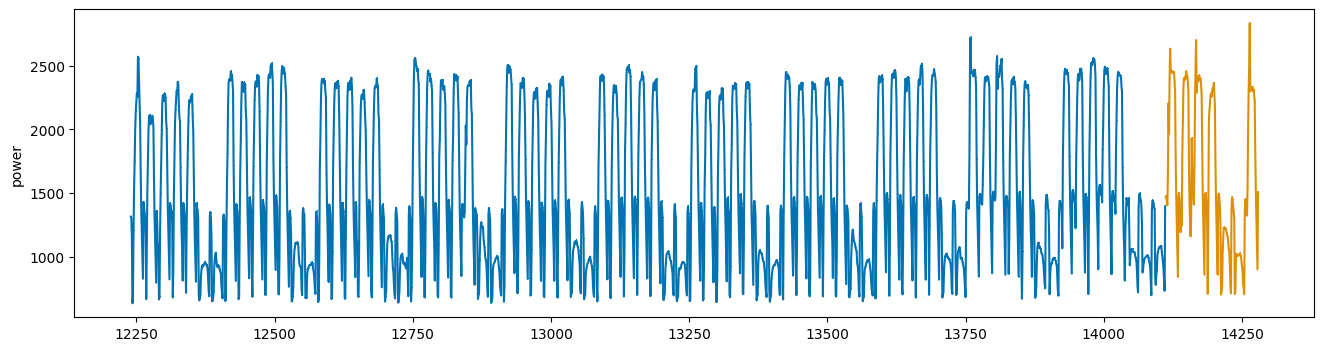

In [20]:
y = train.loc[train.num == 7, 'power']
x = train.loc[train.num == 7, ].iloc[:,3:]

y_train, y_valid, x_train, x_valid = temporal_train_test_split(y = y, X = x, test_size = 168) # 24시간*7일 = 168

print('train data shape\nx:{}, y:{}'.format(x_train.shape, y_train.shape))

plot_series(y_train, y_valid, markers=[',',','])
plt.show()

In [22]:
# SMAPE 손실함수 정의
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true)+np.abs(pred)))*100

In [23]:
print("실제값이 100일 때 50으로 underestimate할 때의 SMAPE : {}".format(SMAPE(100, 50)))
print("실제값이 100일 때 150으로 overestimate할 때의 SMAPE : {}".format(SMAPE(100, 150)))

실제값이 100일 때 50으로 underestimate할 때의 SMAPE : 33.33333333333333
실제값이 100일 때 150으로 overestimate할 때의 SMAPE : 20.0


In [24]:
#### alpha를 argument로 받는 함수로 실제 objective function을 wrapping하여 alpha값을 쉽게 조정할 수 있도록 작성했습니다.
# custom objective function for forcing model not to underestimate

def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

## grad(1차 미분함수) 와 hess(2차 미분함수)를 반환 -> XGBoost에서 목적함수 정의하는 방식임
## residual이 양수일 경우(과소추정) alpha만큼의 가중치가 곱해짐

In [26]:
xgb_params = pd.read_csv('./energy/hyperparameter_xgb.csv')

xgb_reg = XGBRegressor(n_estimators = 10000, eta = xgb_params.iloc[47,1], min_child_weight = xgb_params.iloc[47,2], 
                       max_depth = xgb_params.iloc[47,3], colsample_bytree = xgb_params.iloc[47,4], 
                       subsample = xgb_params.iloc[47,5], seed=0)

xgb_reg.fit(x_train, y_train, eval_set=[(x_train, y_train),(x_valid, y_valid)],
        early_stopping_rounds=300,
       verbose=False)

TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

In [ ]:
## 주황색이 실제 전력소비량, 초록색이 예측값
pred = xgb_reg.predict(x_valid)
pred = pd.Series(pred)
pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])

print('best iterations: {}'.format(xgb_reg.best_iteration))
print('SMAPE : {}'.format(SMAPE(y_valid, pred)))
